In [2]:
import os
folder_path = "data/compound_v2"
os.makedirs(folder_path, exist_ok=True)

print("Folder created at:", folder_path)


Folder created at: data/compound_v2


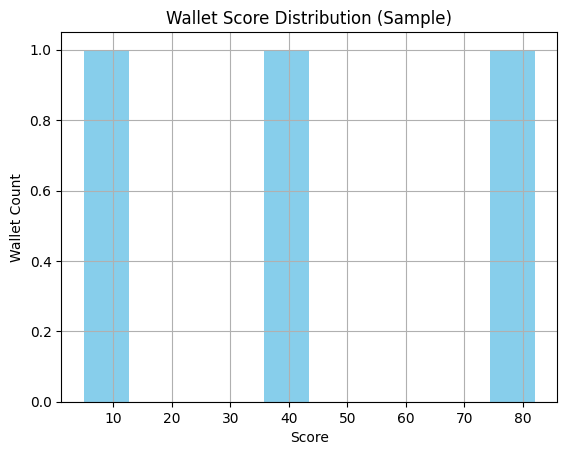

In [11]:
# 1. Imports
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import json

# 2. Create sample JSON data (mock Compound transaction data)
sample_data = [
    {"wallet_address": "0xabc", "timestamp": "2024-06-01T12:00:00Z", "action": "borrow", "amount": 100},
    {"wallet_address": "0xabc", "timestamp": "2024-06-02T13:00:00Z", "action": "repay", "amount": 90},
    {"wallet_address": "0xabc", "timestamp": "2024-06-03T14:00:00Z", "action": "repay", "amount": 10},
    {"wallet_address": "0xabc", "timestamp": "2024-06-04T15:00:00Z", "action": "supply", "amount": 200},
    {"wallet_address": "0xdef", "timestamp": "2024-06-01T10:00:00Z", "action": "borrow", "amount": 300},
    {"wallet_address": "0xdef", "timestamp": "2024-06-01T11:00:00Z", "action": "liquidation", "amount": 250},
    {"wallet_address": "0xdef", "timestamp": "2024-06-01T12:00:00Z", "action": "repay", "amount": 50},
    {"wallet_address": "0x123", "timestamp": "2024-06-10T08:00:00Z", "action": "supply", "amount": 500},
    {"wallet_address": "0x123", "timestamp": "2024-06-15T09:00:00Z", "action": "supply", "amount": 600},
    {"wallet_address": "0x123", "timestamp": "2024-06-20T10:00:00Z", "action": "borrow", "amount": 100}
]

# Save to file
sample_file = 'sample_data.json'
with open(sample_file, 'w') as f:
    json.dump(sample_data, f)

# 3. Load Sample Data
raw_data = pd.read_json(sample_file)
raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])

# 4. Feature Engineering
def extract_wallet_features(df):
    grouped = df.groupby("wallet_address")
    features = []

    for address, group in grouped:
        f = {}
        f["wallet_address"] = address
        f["tx_count"] = len(group)
        f["active_days"] = group["timestamp"].dt.date.nunique()

        borrows = group[group["action"] == "borrow"]
        repays = group[group["action"] == "repay"]
        supplies = group[group["action"] == "supply"]
        liquidations = group[group["action"] == "liquidation"]

        f["total_borrowed"] = borrows["amount"].sum()
        f["total_repaid"] = repays["amount"].sum()
        f["repay_to_borrow_ratio"] = f["total_repaid"] / f["total_borrowed"] if f["total_borrowed"] > 0 else 0
        f["liquidation_count"] = len(liquidations)
        f["supply_count"] = len(supplies)

        timestamps = pd.to_datetime(group["timestamp"]).sort_values()
        time_diffs = timestamps.diff().dropna().dt.total_seconds()
        f["avg_time_between_tx"] = time_diffs.mean() if not time_diffs.empty else 0

        features.append(f)

    return pd.DataFrame(features)

wallet_df = extract_wallet_features(raw_data)

# 5. Normalize & Score
features = ["tx_count", "active_days", "repay_to_borrow_ratio", "supply_count", "avg_time_between_tx"]
scaler = MinMaxScaler()
wallet_df[features] = scaler.fit_transform(wallet_df[features])

weights = {
    "tx_count": 0.2,
    "active_days": 0.2,
    "repay_to_borrow_ratio": 0.3,
    "supply_count": 0.2,
    "avg_time_between_tx": 0.1
}

wallet_df["score"] = sum(wallet_df[feature] * weight for feature, weight in weights.items())
wallet_df["score"] = (wallet_df["score"] * 100).clip(0, 100).round(2)

# 6. Export
wallet_df.sort_values(by="score", ascending=False).to_csv("wallet_scores_sample.csv", index=False)

# 7. Optional: Score Distribution
plt.hist(wallet_df["score"], bins=10, color='skyblue')
plt.title("Wallet Score Distribution (Sample)")
plt.xlabel("Score")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.show()


 Processing compoundV2_transactions_ethereum_chunk_17.json...
 Processing compoundV2_transactions_ethereum_chunk_18.json...
 Processing compoundV2_transactions_ethereum_chunk_19.json...


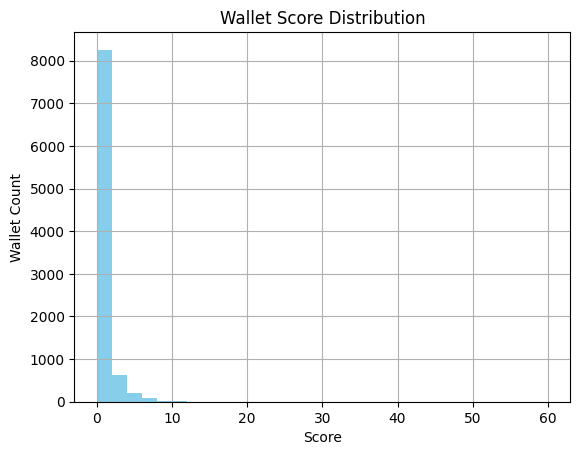

In [21]:

# 1. Imports
import pandas as pd
import numpy as np
import os
import json
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 2. Load Compound JSON files (you must upload them to 'data/compound_v2/' folder)
data_dir = 'data/compound_v2'
files = sorted(
    [f for f in os.listdir(data_dir) if f.endswith('.json')],
    key=lambda x: os.path.getsize(os.path.join(data_dir, x)),
    reverse=True
)[:3]  # Top 3 largest files

dfs = []
for file in files:
    path = os.path.join(data_dir, file)
    print(f" Processing {file}...")
    try:
        with open(path, 'r') as f:
            data = json.load(f)
            # If the file contains 'deposits' array, flatten it
            if "deposits" in data:
                deposit_data = data["deposits"]
                rows = []
                for item in deposit_data:
                    rows.append({
                        "wallet_address": item.get("account", {}).get("id"),
                        "timestamp": pd.to_datetime(int(item.get("timestamp", 0)), unit='s', errors='coerce'),
                        "amount": float(item.get("amount", 0)) / 1e18,  # ETH formatted
                        "amount_usd": float(item.get("amountUSD", 0)),
                        "action": "supply"
                    })
                df = pd.DataFrame(rows)
                dfs.append(df)
    except Exception as e:
        print(f" Failed to load {file}:", e)

if not dfs:
    raise ValueError("No valid JSON files were loaded. Check your file format or path.")

# 3. Combine and preprocess
raw_data = pd.concat(dfs, ignore_index=True)
raw_data = raw_data.dropna(subset=['timestamp', 'wallet_address', 'amount'])

# 4. Feature Engineering
def extract_wallet_features(df):
    grouped = df.groupby("wallet_address")
    features = []

    for address, group in grouped:
        f = {}
        f["wallet_address"] = address
        f["tx_count"] = len(group)
        f["active_days"] = group["timestamp"].dt.date.nunique()

        borrows = group[group["action"] == "borrow"]
        repays = group[group["action"] == "repay"]
        supplies = group[group["action"] == "supply"]
        liquidations = group[group["action"] == "liquidation"]

        f["total_borrowed"] = borrows["amount"].sum() if not borrows.empty else 0
        f["total_repaid"] = repays["amount"].sum() if not repays.empty else 0
        f["repay_to_borrow_ratio"] = f["total_repaid"] / f["total_borrowed"] if f["total_borrowed"] > 0 else 0
        f["liquidation_count"] = len(liquidations)
        f["supply_count"] = len(supplies)

        timestamps = pd.to_datetime(group["timestamp"]).sort_values()
        time_diffs = timestamps.diff().dropna().dt.total_seconds()
        f["avg_time_between_tx"] = time_diffs.mean() if not time_diffs.empty else 0

        features.append(f)

    return pd.DataFrame(features)

wallet_df = extract_wallet_features(raw_data)

# 5. Normalize & Score
features = ["tx_count", "active_days", "repay_to_borrow_ratio", "supply_count", "avg_time_between_tx"]
scaler = MinMaxScaler()
wallet_df[features] = scaler.fit_transform(wallet_df[features])

weights = {
    "tx_count": 0.2,
    "active_days": 0.2,
    "repay_to_borrow_ratio": 0.3,
    "supply_count": 0.2,
    "avg_time_between_tx": 0.1
}

wallet_df["score"] = sum(wallet_df[feature] * weight for feature, weight in weights.items())
wallet_df["score"] = (wallet_df["score"] * 100).clip(0, 100).round(2)

# 6. Export
wallet_df.sort_values(by="score", ascending=False).to_csv("wallet_scores.csv", index=False)

# 7. Optional: Score Distribution
plt.hist(wallet_df["score"], bins=30, color='skyblue')
plt.title("Wallet Score Distribution")
plt.xlabel("Score")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.show()


In [15]:
top_wallets = wallet_df.sort_values(by="score", ascending=False).head(1000)
top_wallets.to_csv("top_1000_wallet_scores.csv", index=False)


In [22]:
# High scorers
high = top_wallets.head(5)
print("Top Wallets:\n", high)
print("------------------------------------------------------------------------------")
# Low scorers
low = wallet_df.sort_values(by="score").head(5)
print("\nBottom Wallets:\n", low)


Top Wallets:
                                   wallet_address  tx_count  active_days  \
1568  0x29fe7d60ddf151e5b52e5fab4f1325da6b2bd958  1.000000     1.000000   
18    0x0034ea9808e620a0ef79261c51af20614b742b24  0.285132     1.000000   
1     0x00000000001876eb1444c986fd502e618c587430  0.300916     0.948718   
5185  0x8f2d580c3cccd96c3541386daac0af71c5d1c0f9  0.320774     0.846154   
5902  0xa2b47e3d5c44877cca798226b7b8118f9bfb7a56  0.203157     0.743590   

      total_borrowed  total_repaid  repay_to_borrow_ratio  liquidation_count  \
1568               0             0                    0.0                  0   
18                 0             0                    0.0                  0   
1                  0             0                    0.0                  0   
5185               0             0                    0.0                  0   
5902               0             0                    0.0                  0   

      supply_count  avg_time_between_tx  score  
1568 